In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import affinity
from shapely.ops import unary_union
import math

# Define Tree Geometry
def get_tree_polygon(x=0, y=0, angle=0):
    trunk_w = 0.15
    trunk_h = 0.2
    base_w = 0.7
    mid_w = 0.4
    top_w = 0.25
    tip_y = 0.8
    tier_1_y = 0.5
    tier_2_y = 0.25
    base_y = 0.0
    trunk_bottom_y = -trunk_h
    
    coords = [
        (0.0, tip_y),
        (top_w/2, tier_1_y), (top_w/4, tier_1_y),
        (mid_w/2, tier_2_y), (mid_w/4, tier_2_y),
        (base_w/2, base_y),
        (trunk_w/2, base_y), (trunk_w/2, trunk_bottom_y),
        (-trunk_w/2, trunk_bottom_y), (-trunk_w/2, base_y),
        (-base_w/2, base_y),
        (-mid_w/4, tier_2_y), (-mid_w/2, tier_2_y),
        (-top_w/4, tier_1_y), (-top_w/2, tier_1_y)
    ]
    
    poly = Polygon(coords)
    if angle != 0:
        poly = affinity.rotate(poly, angle, origin=(0, 0))
    if x != 0 or y != 0:
        poly = affinity.translate(poly, xoff=x, yoff=y)
    return poly

tree_area = get_tree_polygon().area
print(f"Tree Area: {tree_area}")


Tree Area: 0.24562500000000004


In [2]:
# Function to check overlap for a given lattice
def check_lattice_overlap(v1, v2, trees_in_unit_cell):
    """
    Checks if trees in the unit cell overlap with neighbors in the lattice.
    v1, v2: Lattice vectors (tuples)
    trees_in_unit_cell: list of shapely Polygons
    
    Returns: True if overlap detected, False otherwise
    """
    # Check self-overlap (within unit cell)
    for i in range(len(trees_in_unit_cell)):
        for j in range(i + 1, len(trees_in_unit_cell)):
            if trees_in_unit_cell[i].intersects(trees_in_unit_cell[j]):
                return True

    # Check neighbor overlap
    # We need to check enough neighbors. For a dense packing, checking immediate neighbors (radius 1 or 2) is usually enough.
    search_radius = 2
    
    for i in range(-search_radius, search_radius + 1):
        for j in range(-search_radius, search_radius + 1):
            if i == 0 and j == 0:
                continue
                
            dx = i * v1[0] + j * v2[0]
            dy = i * v1[1] + j * v2[1]
            
            for tree_base in trees_in_unit_cell:
                # Translate tree by lattice vector
                tree_shifted = affinity.translate(tree_base, xoff=dx, yoff=dy)
                
                for tree_target in trees_in_unit_cell:
                    if tree_shifted.intersects(tree_target):
                        # Use a small buffer for numerical stability if needed, but shapely is usually fine
                        # Intersection area check might be more robust than simple boolean intersects
                        if tree_shifted.intersection(tree_target).area > 1e-6:
                            return True
    return False

# Visualization
def plot_lattice(v1, v2, trees_in_unit_cell, n_repeats=3):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for i in range(-n_repeats, n_repeats + 1):
        for j in range(-n_repeats, n_repeats + 1):
            dx = i * v1[0] + j * v2[0]
            dy = i * v1[1] + j * v2[1]
            
            for tree in trees_in_unit_cell:
                tree_shifted = affinity.translate(tree, xoff=dx, yoff=dy)
                x, y = tree_shifted.exterior.xy
                ax.fill(x, y, alpha=0.5, edgecolor='black')
                
    ax.set_aspect('equal')
    plt.show()


Best Single Lattice Area: 0.5417761479591838
Params (dx, dy, shift): (0.7996093750000001, 0.6775510204081634, -0.4)
Density: 0.4533699036497725


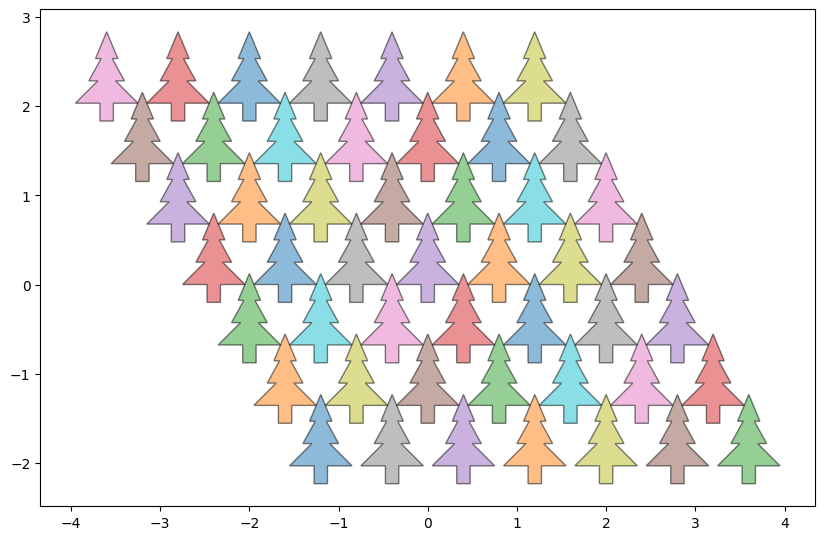

In [3]:
# Optimization Strategy:
# We will use a simple grid search or optimization loop to find the best lattice vectors.
# Since we suspect 0 and 180 degrees are optimal, we focus on that.

# Scenario 1: Single Lattice (All 0 degrees)
# Lattice vectors: v1 = (dx, 0), v2 = (shift_x, dy)
# We want to minimize dx * dy.

def optimize_single_lattice_0deg():
    best_area = float('inf')
    best_params = None
    
    # Coarse grid search
    # dx must be at least width of tree approx 0.7
    # dy must be at least height of tree approx 1.0
    
    # Actually, they can interlock, so dy can be smaller if shift_x is used.
    
    # Let's try to find the "kissing" distance.
    # Fix y-spacing, find min x-spacing.
    
    t0 = get_tree_polygon(0, 0, 0)
    
    # Grid search ranges
    dy_range = np.linspace(0.2, 1.1, 50) # Height is 1.0 (0.8 - -0.2)
    shift_range = np.linspace(-0.4, 0.4, 20)
    
    for dy in dy_range:
        for shift in shift_range:
            # Binary search for min dx
            low = 0.1
            high = 1.0
            min_dx = high
            
            # Check if valid at high
            v1 = (high, 0)
            v2 = (shift, dy)
            if check_lattice_overlap(v1, v2, [t0]):
                continue # Even at max spacing it overlaps? Unlikely.
            
            for _ in range(10):
                mid = (low + high) / 2
                v1 = (mid, 0)
                v2 = (shift, dy)
                if check_lattice_overlap(v1, v2, [t0]):
                    low = mid
                else:
                    min_dx = mid
                    high = mid
            
            # Calculate area
            # Area of parallelogram = base * height = dx * dy
            area = min_dx * dy
            if area < best_area:
                best_area = area
                best_params = (min_dx, dy, shift)
                
    return best_area, best_params

best_area_single, params_single = optimize_single_lattice_0deg()
print(f"Best Single Lattice Area: {best_area_single}")
print(f"Params (dx, dy, shift): {params_single}")
print(f"Density: {tree_area / best_area_single}")

t0 = get_tree_polygon(0, 0, 0)
v1 = (params_single[0], 0)
v2 = (params_single[2], params_single[1])
plot_lattice(v1, v2, [t0])


Best Double Lattice Area per Tree: 0.45
Params (dx, sy, rx, ry, v2x, v2y): (0.9, 1.0, 0.45, 0.4666666666666667, 0, 1.0)
Density: 0.5458333333333334


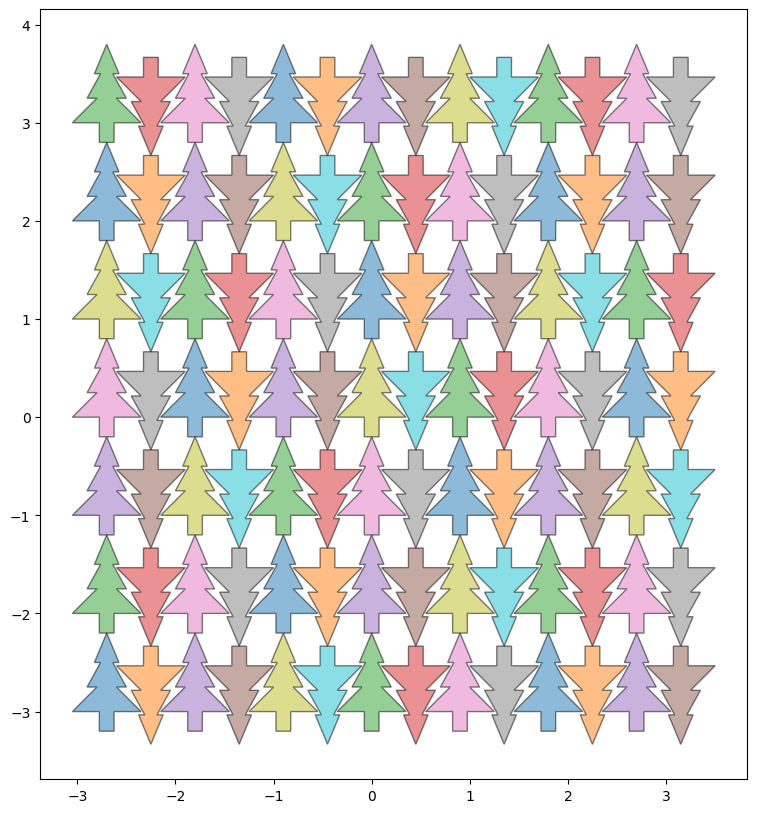

In [5]:
# Scenario 2: Double Lattice (0 and 180 degrees)
# We assume a pattern where 180-deg trees fill gaps.
# Pattern:
# Row 0: ... T(0) ... T(0) ... (spacing dx)
# Row 0.5: ... T(180) ... T(180) ... (spacing dx, shifted by rx, ry relative to Row 0)
# Row 1: ... T(0) ... (spacing dx, shifted by sx, sy relative to Row 0)

# If we assume a periodic lattice of PAIRS:
# Unit cell: T1(0,0,0), T2(rx, ry, 180)
# Lattice: v1=(dx, 0), v2=(sx, sy)
# We want to minimize |dx * sy| (assuming v1 aligned).

def optimize_double_lattice_grid():
    best_area_per_tree = float('inf')
    best_params = None
    
    t1 = get_tree_polygon(0, 0, 0)
    
    # Grid search
    # dx: width of tree is 0.7. Spacing likely > 0.7? 
    # No, if T2 is between T1s, T1s can be far apart? 
    # Actually, if T2 is between T1s, dx is determined by how wide the T1-T2-T1 sandwich is.
    # But T1 and T2 overlap in x-projection.
    
    # Let's try dx in [0.4, 1.0]
    # ry in [0.0, 0.5] (vertical overlap)
    # rx in [0.0, 0.5] (horizontal offset)
    # sy in [0.5, 1.2] (vertical spacing of pairs)
    # sx in [-0.5, 0.5]
    
    # To save time, let's assume rx = dx/2 (centered in gap)
    # And sx = dx/2 (hexagonal-like packing of pairs) or sx=0 (rectangular)
    
    dx_range = np.linspace(0.4, 0.9, 10)
    ry_range = np.linspace(0.0, 0.6, 10) # Relative Y of inverted tree
    sy_range = np.linspace(0.4, 1.0, 10) # Vertical step to next pair
    
    # We will fix rx = dx/2 and sx = 0 for now (Rectangular grid of pairs)
    # This means:
    # T1 at (0,0), T2 at (dx/2, ry)
    # Next T1 at (0, sy), Next T2 at (dx/2, ry+sy)
    # v1 = (dx, 0)
    # v2 = (0, sy)
    
    for dx in dx_range:
        for ry in ry_range:
            for sy in sy_range:
                rx = dx / 2
                
                t2 = get_tree_polygon(rx, ry, 180)
                
                v1 = (dx, 0)
                v2 = (0, sy)
                
                # Check overlap
                if check_lattice_overlap(v1, v2, [t1, t2]):
                    continue
                
                # Area per tree = (dx * sy) / 2
                area = (dx * sy) / 2
                if area < best_area_per_tree:
                    best_area_per_tree = area
                    best_params = (dx, sy, rx, ry, 0, sy) # v1=(dx,0), v2=(0,sy)
                    
    return best_area_per_tree, best_params

best_area_double, params_double = optimize_double_lattice_grid()
print(f"Best Double Lattice Area per Tree: {best_area_double}")
print(f"Params (dx, sy, rx, ry, v2x, v2y): {params_double}")
print(f"Density: {tree_area / best_area_double}")

if params_double:
    dx, sy, rx, ry, v2x, v2y = params_double
    t1 = get_tree_polygon(0, 0, 0)
    t2 = get_tree_polygon(rx, ry, 180)
    v1 = (dx, 0)
    v2 = (v2x, v2y)
    plot_lattice(v1, v2, [t1, t2])


In [ ]:
def optimize_double_lattice_refined():
    best_area_per_tree = float('inf')
    best_params = None
    
    t1 = get_tree_polygon(0, 0, 0)
    
    # Refined grid search around previous best
    # dx: 0.8 to 1.2
    # sy: 0.8 to 1.2
    # ry: 0.3 to 0.6
    # sx: -0.5 to 0.5 (Shear)
    
    dx_range = np.linspace(0.8, 1.2, 10)
    sy_range = np.linspace(0.8, 1.2, 10)
    ry_range = np.linspace(0.3, 0.6, 8)
    sx_range = np.linspace(-0.4, 0.4, 8)
    
    for dx in dx_range:
        for ry in ry_range:
            rx = dx / 2 # Keep centered horizontally
            t2 = get_tree_polygon(rx, ry, 180)
            
            for sy in sy_range:
                for sx in sx_range:
                    v1 = (dx, 0)
                    v2 = (sx, sy)
                    
                    if check_lattice_overlap(v1, v2, [t1, t2]):
                        continue
                    
                    area = (dx * sy) / 2
                    if area < best_area_per_tree:
                        best_area_per_tree = area
                        best_params = (dx, sy, rx, ry, sx, sy)
                        
    return best_area_per_tree, best_params

best_area_refined, params_refined = optimize_double_lattice_refined()
print(f"Best Refined Area per Tree: {best_area_refined}")
print(f"Params (dx, sy, rx, ry, v2x, v2y): {params_refined}")
print(f"Density: {tree_area / best_area_refined}")

if params_refined:
    dx, sy, rx, ry, v2x, v2y = params_refined
    t1 = get_tree_polygon(0, 0, 0)
    t2 = get_tree_polygon(rx, ry, 180)
    v1 = (dx, 0)
    v2 = (v2x, v2y)
    plot_lattice(v1, v2, [t1, t2])
